Scene-Text Detection

In [1]:
# Loading all necessary libraries and modules
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec

from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

In [55]:
def get_cwd(join_ch):
    dir = os.getcwd().strip().replace("\\", join_ch)
    dir = dir.split(join_ch)[:-1]
    dir = join_ch.join(dir)+join_ch
    return dir

In [56]:
main_dir = get_cwd("/")
code_dir = os.path.join(main_dir, 'Code')
dataset_dir = os.path.join(main_dir, 'Datasets')

In [4]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model = ResNet50(weights = 'imagenet', include_top = False)

In [5]:
def preprocess_image(base_model:str, image_path:str, resize:tuple):
    orig = cv.imread(image_path)
    image = cv.cvtColor(orig, cv.COLOR_BGR2RGB)
    image = cv.resize(image, resize).reshape(-1, resize[0], resize[1], 3)
    if base_model == "resnet50":
        image = preprocess_input(image)
    if base_model == "vgg16":
        image = preprocess_input_vgg16(image)

    return orig, image

I want to look how extracted features looks like, so I'll load one images and visualize it:

In [69]:
# Read image
orig, image = preprocess_image('resnet50', os.path.join(dataset_dir, 'IIIT5K/train/Text/6_7.png'), (224, 224))
features = model.predict(image)

features.shape
os.path.join(dataset_dir, 'IIIT5K/train/Text/6_7.png')

'e:/Gustovalley/PhD Projects/Text segmentation/Git-Repo/Datasets\\IIIT5K/train/Text/6_7.png'

Now "features" array contains 2048 feature maps wits 7x7 size.

I want to plot random 9 features as example:

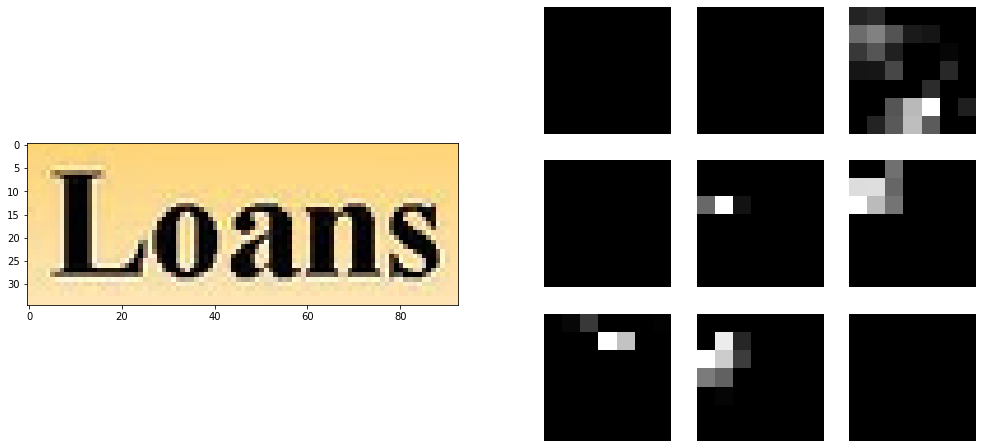

In [7]:
n_features = features.shape[-1]

fig = plt.figure(figsize = (17, 8))
gs = gridspec.GridSpec(1, 2, figure = fig)
sub_gs = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(orig)

for i in range(3):
    for j in range(3):
        ax2 = fig.add_subplot(sub_gs[i, j])
        plt.axis('off')        
        plt.imshow(features[0, :, :, np.random.randint(n_features)], cmap = 'gray') 

In [8]:
model_vgg16 = VGG16(weights = 'imagenet', include_top = False)
model_vgg16 = Model(inputs=model_vgg16.inputs, outputs=model_vgg16.layers[1].output)
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [9]:
orig, image = preprocess_image('vgg16', '../Datasets/IIIT5K/train/Text/6_7.png', (224, 224))
features_vgg16 = model_vgg16.predict(image)

features_vgg16.shape

(1, 224, 224, 64)

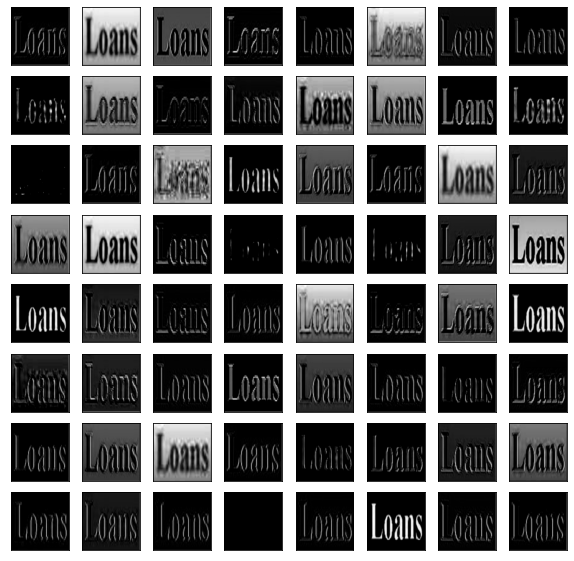

In [10]:
square = 8
ix = 1
fig = plt.figure(figsize = (10, 10))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(features_vgg16[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()

In [ ]:
def read_gt(filepath):
    with open(filepath, 'r') as f:
        data = [txt.split(" ") for txt in f.readlines()]
        final = [each[:-1]+[each[-1].split('"')[1]] for each in data]
    return final

On next step I want to prepare data for training and evaluation.

In [76]:

dataset_path = os.path.join(dataset_dir, "IIIT5K")

sets = ['train','val','test']
label = {"Text": 0, "Non-Text": 1}

train_X, train_Y, train_NT_X, train_NT_Y = ([], [], [], [])
val_X, val_Y, val_NT_X, val_NT_Y = ([], [], [], [])
test_X, test_Y, test_NT_X, test_NT_Y = ([], [], [], [])

text_data = [(train_X, train_Y), (val_X, val_Y), (test_X, test_Y)]
non_text_data = [(train_NT_X, train_NT_Y), (val_NT_X, val_NT_Y), (test_NT_X, test_NT_Y)]

def prepare_dataset(model, data, data_path, data_label, folder_set):
    for s, dat in (zip(folder_set, data)):
        path_to_images = os.path.join(data_path, s)
        path_to_images = os.path.join(path_to_images, data_label)
        for img in os.listdir(path_to_images):
            try:
                if img[-3:] == 'png':
                    image_path = os.path.join(path_to_images, img)
                    orig, image = preprocess_image('resnet50', image_path, (224, 224)) # (224, 224) = size to be resized
                    features = model.predict(image).reshape(100352) # 7*7*2048 = 100352 nodes flattening
                    dat[0].append(features)
                    dat[1].append(label[data_label])
            except:
                pass

    return data

In [77]:
text_data = prepare_dataset(model, text_data, dataset_path, "Text", sets)

In [78]:
non_text_data = prepare_dataset(model, non_text_data, dataset_path, "Non-Text", sets)

In [79]:
# Shuffle data in each split
random_state = 1
train_X, train_Y = shuffle(train_X, train_Y, random_state = random_state)
val_X, val_Y = shuffle(val_X, val_Y, random_state = random_state)
test_X, test_Y = shuffle(test_X, test_Y, random_state = random_state)

In [80]:
train_NT_X, train_NT_Y = shuffle(train_NT_X, train_NT_Y, random_state = random_state)
val_NT_X, val_NT_Y = shuffle(val_NT_X, val_NT_Y, random_state = random_state)
test_NT_X, test_NT_Y = shuffle(test_NT_X, test_NT_Y, random_state = random_state)

In [81]:
# Convert data to numpy arrays
train_X = np.array(train_X)
train_Y = np.array(train_Y)

val_X = np.array(val_X)
val_Y = np.array(val_Y)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

In [82]:
# Convert data to numpy arrays
train_NT_X = np.array(train_NT_X)
train_NT_Y = np.array(train_NT_Y)

val_NT_X = np.array(val_NT_X)
val_NT_Y = np.array(val_NT_Y)

test_NT_X = np.array(test_NT_X)
test_NT_Y = np.array(test_NT_Y)

In [ ]:
X_train = np.concatenate(train_X, train_NT_X, axis=0)

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape = (100352,), activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(1, activation = 'sigmoid'))

# Checkpoint to save best model
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(train_X, train_Y, batch_size = 64, epochs = 10, validation_data = [val_X, val_Y], callbacks = [checkpoint])

# Plot losses and accuracies
history = model.history.history

fig = plt.figure(figsize = (8, 5))
plt.plot(history['accuracy'], label = 'acc')
plt.plot(history['val_accuracy'], label = 'val_acc')
plt.plot(history['loss'], label = 'acc')
plt.plot(history['val_loss'], label = 'acc')
plt.grid()
plt.legend()
plt.show()

In [ ]:
model.load_weights('best_model.hdf5')
model.evaluate(test_X, test_Y)

In [ ]:
# Making predictions using evaluation dataset
preds = model.predict(test_X)

# If our prediction more than 0.5 - we round it to 1, else to 0
preds = [1 if i > 0.5 else 0 for i in preds]

# Calculating accuracy score
accuracy = accuracy_score(test_Y, preds)
print(f'Accuracy: {round(accuracy * 100, 4)}%')

# Plotting confusion matrix
l = ['text']
confusion = confusion_matrix(test_Y, preds)
sns.heatmap(confusion, square = True, fmt = 'd', xticklabels = l, yticklabels = l, annot = True)